# Group-based Classification Models

### Importing libraries and define functions

In [1]:
import pandas as pd
import numpy as np
import scipy
import math
import os
import sys

In [2]:
# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [3]:
import sklearn
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

In [4]:
from pycaret.classification import *

In [5]:
import functions as f

# Carbon-based NMs classification model

In [6]:
model_name = "carbon_based"
group_name = "carbon"
seed = 123

### Load the data and filter instances

In [7]:
data_train_df = pd.read_csv("output/datasets/universal/data_classification_train_df.csv", encoding="utf-8")
data_test_df = pd.read_csv("output/datasets/universal/data_classification_test_df.csv", encoding="utf-8")
data_df = pd.concat([data_train_df,data_test_df])

del data_train_df
del data_test_df

In [8]:
data_df.shape

(11315, 20)

In [9]:
data_group_df = data_df[data_df['nanomaterial_group'] == group_name]

In [10]:
data_group_df.shape

(212, 20)

In [11]:
data_group_df.head()

,NP_type,Coating,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,shape,Dose_microg_mL,Duration_h,Cell_name,Cell_species,cell_Organ,Cell_morphology,Cell_age,cell_type,sex,Assay,Test_indicator,nanomaterial_group,viability_class
123,Carbon,SO3Na,5.9,NaN,NaN,NaN,NaN,0.69,24.0,Neuro­2a,Mouse,Brain,Neural,Adult,cancer,NaN,MTT,TetrazoliumSalt,carbon,NonToxic
262,Carbon,COOH,5.9,NaN,NaN,NaN,NaN,0.69,24.0,Neuro­2a,Mouse,Brain,Neural,Adult,cancer,NaN,MTT,TetrazoliumSalt,carbon,NonToxic
282,C60,None,76.0,NaN,-36.0,NaN,Sphere,20.00,24.0,V79,Hamster,Lung,Fibroblast,Adult,Normal,male,MTT,TetrazoliumSalt,carbon,NonToxic
315,Carbon,None,60.0,NaN,NaN,NaN,NaN,0.00,48.0,HDF,Human,Skin,Fibroblast,Adult,Normal,NaN,Live/Dead,CalceinAM,carbon,NonToxic
440,Carbon,SO3Na,5.9,NaN,NaN,NaN,NaN,0.07,24.0,Neuro­2a,Mouse,Brain,Neural,Adult,cancer,NaN,MTT,TetrazoliumSalt,carbon,NonToxic


### Create training set and test set

In [12]:
splitter = setup(data = data_group_df, target = 'viability_class',
                 preprocess = False,
                 train_size=0.8,
                 data_split_stratify=True,
                 # don't change the following
                 session_id = seed,
                 use_gpu=False,
                 log_experiment = False,
                 silent=True,
                 experiment_name = 'splitter')

,Description,Value
0,session_id,123
1,Target,viability_class
2,Target Type,Binary
3,Label Encoded,"NonToxic: 0, Toxic: 1"
4,Original Data,"(212, 20)"
5,Missing Values,True
6,Numeric Features,5
7,Categorical Features,14
8,Transformed Train Set,"(169, 18)"
9,Transformed Test Set,"(43, 18)"


In [13]:
data_group_train_df = get_config(variable="X_train").copy()
data_group_train_df['viability_class'] = get_config(variable="y_train").copy()

data_group_test_df = get_config(variable="X_test").copy()
data_group_test_df['viability_class'] = get_config(variable="y_test").copy()

In [14]:
print(data_group_train_df.shape)
print(data_group_test_df.shape)

(169, 19)
(43, 19)


In [15]:
print(data_group_train_df['viability_class'].value_counts())
print(data_group_test_df['viability_class'].value_counts())

0    154
1     15
Name: viability_class, dtype: int64
0    39
1     4
Name: viability_class, dtype: int64


### Save cleaned datasets

In [16]:
data_group_train_df.to_csv('output/datasets/'+model_name+'/data_classification_'+model_name+'_train_df.csv', encoding='utf-8', index=False)

In [17]:
data_group_test_df.to_csv('output/datasets/'+model_name+'/data_classification_'+model_name+'_test_df.csv', encoding='utf-8', index=False)

### Use the best scenario identified in step 01

In [18]:
sc_ignore_features = ['nanomaterial_group', 'Coating', 'Cell_name']
sc_bin_numeric_features = None
sc_high_cardinality_features = None

sc_imputation_type = 'iterative'
sc_numeric_imputation = 'mean'

sc_normalize = True
sc_remove_outliers = True

### Data Preprcoessing

In [19]:
stup = setup(data = data_group_train_df, target = 'viability_class', 
              
        test_data = data_group_test_df,

        imputation_type = sc_imputation_type, 
        numeric_imputation = sc_numeric_imputation, #default: mean

        categorical_imputation = "constant", #default: constant
        iterative_imputation_iters = 5, #default: 5
        numeric_iterative_imputer = "lightgbm",
        categorical_iterative_imputer = "lightgbm",

        ignore_features = sc_ignore_features,
        bin_numeric_features = sc_bin_numeric_features,
        high_cardinality_features = sc_high_cardinality_features,

        high_cardinality_method = "frequency", #default: frequency
        handle_unknown_categorical = True, #default
        unknown_categorical_method = "least_frequent", #default

        normalize = sc_normalize, #default: False
        remove_outliers= sc_remove_outliers, #default: False

        outliers_threshold = 0.05, #default

        transformation= False, #default
        transformation_method = 'yeo-johnson', #default
        combine_rare_levels = False,
        rare_level_threshold = 0.1, #default: 0.1

        remove_multicollinearity = False, #default 
        multicollinearity_threshold = 0.9, #default

        ignore_low_variance = True, 

        feature_interaction = False, 
        feature_ratio = False,
        polynomial_features = False, 
        trigonometry_features = False,

        fix_imbalance = True,
        #fix_imbalance_method = SMOTE, # default
        
        # don't change the following
        session_id = seed,
        use_gpu=False,
        log_experiment = False,
        silent=True,
        experiment_name = model_name)

set_config('seed', seed)

,Description,Value
0,session_id,123
1,Target,viability_class
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(169, 19)"
5,Missing Values,True
6,Numeric Features,5
7,Categorical Features,10
8,Ordinal Features,False
9,High Cardinality Features,False


In [20]:
print(get_config(variable="X_train").shape)
print(get_config(variable="y_train").shape)

(160, 37)
(160,)


In [21]:
print(get_config(variable="X").shape)
print(get_config(variable="y").shape)

(169, 37)
(169,)


In [22]:
set_config('X_train', get_config(variable="X").copy()) 
set_config('y_train', get_config(variable="y").copy()) 

In [23]:
print(get_config(variable="X_train").shape)
print(get_config(variable="y_train").shape)

(169, 37)
(169,)


In [24]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(43, 37)
(43,)


In [25]:
#load_config('output/models/universal_regression_rf.cfg')

In [26]:
data_group_train_transformed_df = get_config(variable="X").copy()
data_group_train_transformed_df['viability_class'] = get_config(variable="y").copy()

In [27]:
data_group_test_transformed_df = get_config(variable="X_test").copy()
data_group_test_transformed_df['viability_class'] = get_config(variable="y_test").copy()

In [28]:
data_group_train_transformed_df.to_csv('output/datasets/'+model_name+'/transformed/data_classification_'+model_name+'_train_transformed_df.csv', encoding='utf-8', index=False)
data_group_test_transformed_df.to_csv('output/datasets/'+model_name+'/transformed/data_classification_'+model_name+'_test_transformed_df.csv', encoding='utf-8', index=False)

### Model Comparison

In [29]:
top_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9114,0.7235,0.5500,0.5000,0.5033,0.4581,0.4704,2.2650
dummy,Dummy Classifier,0.9114,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0050
rf,Random Forest Classifier,0.8938,0.7540,0.4500,0.3500,0.3700,0.3156,0.3326,0.0790
et,Extra Trees Classifier,0.8938,0.8065,0.5500,0.4333,0.4600,0.4056,0.4229,0.0680
ada,Ada Boost Classifier,0.8761,0.7448,0.5500,0.3583,0.4200,0.3581,0.3758,0.0190
xgboost,Extreme Gradient Boosting,0.8761,0.7140,0.5500,0.4000,0.4300,0.3653,0.3899,0.0610
lightgbm,Light Gradient Boosting Machine,0.8761,0.7131,0.5500,0.3583,0.4000,0.3354,0.3654,0.0130
gbc,Gradient Boosting Classifier,0.8643,0.6415,0.4500,0.3083,0.3400,0.2685,0.2899,0.0190
dt,Decision Tree Classifier,0.8585,0.6646,0.4500,0.2983,0.3305,0.2565,0.2806,0.0040
lr,Logistic Regression,0.7934,0.8154,0.7500,0.2733,0.3936,0.2995,0.3561,0.3840


In [30]:
results_df = pull()

results_df = results_df.reset_index(level=0)

results_df.to_csv('output/models_results/'+model_name+'/' + model_name + '_classification_model_comparison_results.tsv', 
                index=False, encoding="utf-8", sep="\t")

In [31]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(43, 37)
(43,)


In [32]:
print(results_df.iloc[0,0])

catboost


### 10-fold cross-validation of the best performing model

In [33]:
model = create_model(results_df.iloc[0,0])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9412,0.8125,0.0000,0.0000,0.0000,0.0000,0.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.8824,0.4062,0.0000,0.0000,0.0000,-0.0625,-0.0625
4,0.8824,0.5167,0.5000,0.5000,0.5000,0.4333,0.4333
5,0.7647,0.3667,0.0000,0.0000,0.0000,-0.1333,-0.1333
6,0.8235,0.5000,0.5000,0.3333,0.4000,0.3014,0.3099
7,0.9412,0.7000,0.5000,1.0000,0.6667,0.6383,0.6847
8,0.9412,0.9667,1.0000,0.6667,0.8000,0.7671,0.7888


In [34]:
results_df = pull()

results_df = results_df.reset_index(level=0)

results_df.to_csv('output/models_results/'+model_name+'/' + model_name + '_classification_model_cross_validation_results.tsv', 
                index=False, encoding="utf-8", sep="\t")

In [35]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(43, 37)
(43,)


### Finalize the model

In [36]:
final_model = finalize_model(model)

In [37]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(43, 37)
(43,)


### Test the model on the test set

In [38]:
pred_test_set = predict_model(final_model, data=data_group_test_df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8837,0.9263,0.5000,0.4000,0.4444,0.3804,0.3834


In [39]:
results_df = pull()

results_df = results_df.reset_index(level=0)

results_df.to_csv('output/models_results/'+model_name+'/' + model_name + '_classification_model_test_set_validation_results.tsv', 
                index=False, encoding="utf-8", sep="\t")

In [40]:
predict_model(final_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8837,0.9263,0.5000,0.4000,0.4444,0.3804,0.3834


,core_size_nm,hydro_size_nm,Surf_charge_mV,Dose_microg_mL,Duration_h,NP_type_C60,NP_type_C70,NP_type_Carbon,NP_type_Diamond,NP_type_Graphite,...,Cell_age_neonate,cell_type_Normal,Assay_Live/Dead,Assay_MTT,Assay_NR,Assay_WST-1,Test_indicator_TetrazoliumSalt,viability_class,Label,Score
0,0.109238,-0.385043,-0.762657,-0.381818,-0.123801,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,0.9503
1,-0.191144,-1.218321,-0.847826,0.696084,-0.123801,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1,0,0.8625
2,-0.006964,-0.385043,-0.890679,-0.438550,2.003901,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,1,0.8717
3,-0.191144,-1.218321,-0.847826,-0.325087,-1.719578,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,0.9835
4,0.109238,-0.335210,-0.762657,-0.211623,-0.123801,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,0.9096
5,-0.413671,1.037728,-0.738323,0.696084,-0.123801,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,0.9881
6,-0.222736,1.789376,0.812967,0.015303,-0.123801,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.9516
7,-0.224843,1.037728,0.399290,1.830718,-0.123801,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.8333
8,-0.413671,1.037728,-0.738323,-0.211623,-2.074194,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,0.9877
9,0.756701,-0.385043,-0.890679,-0.438550,-0.123801,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0,0,0.9701


### Inspect model plots

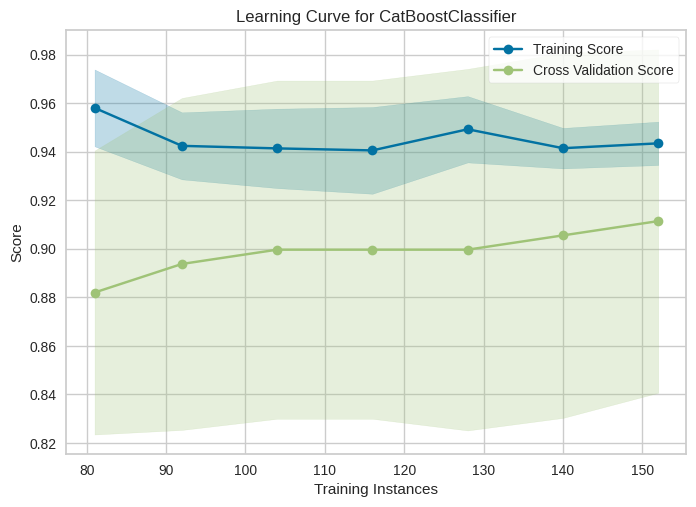

In [41]:
plot_model(final_model, plot = 'learning')

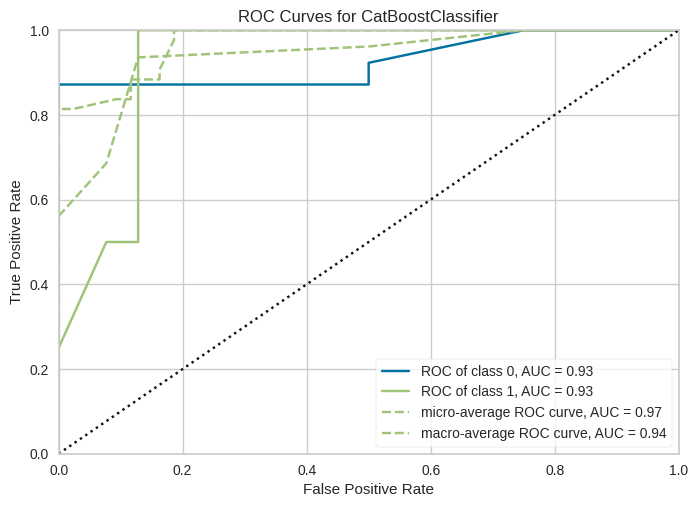

In [42]:
plot_model(final_model, plot = 'auc')

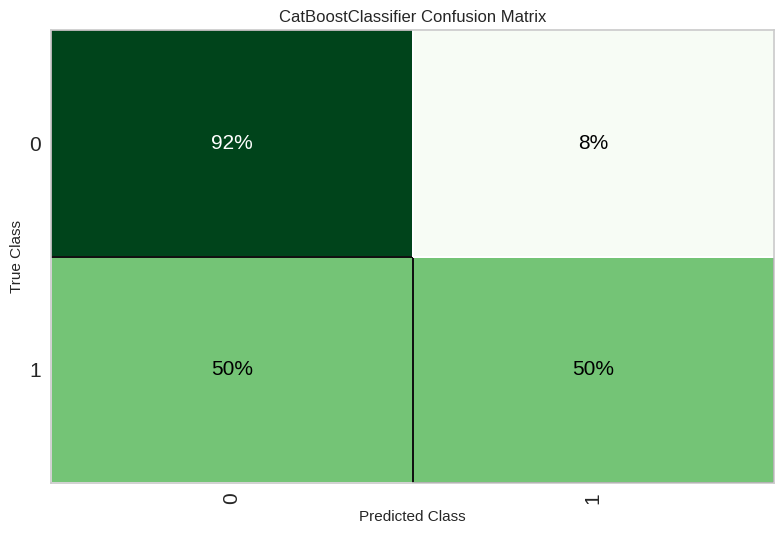

In [43]:
plot_model(final_model, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

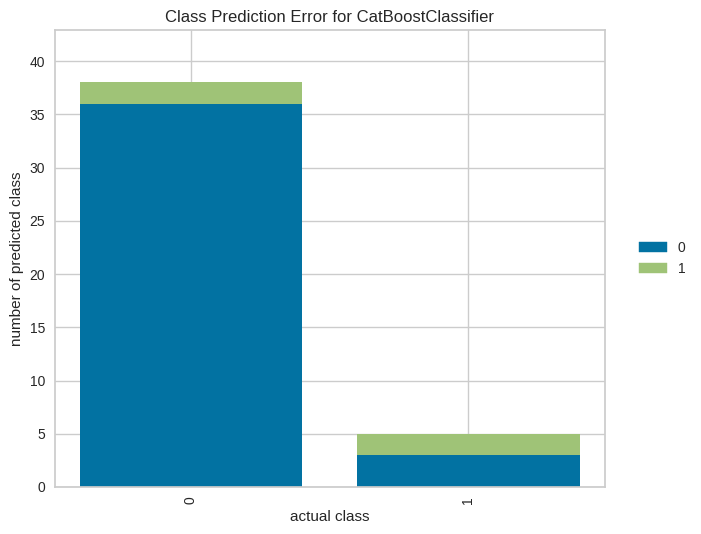

In [44]:
plot_model(final_model, plot = 'error')

### Feature importance plot

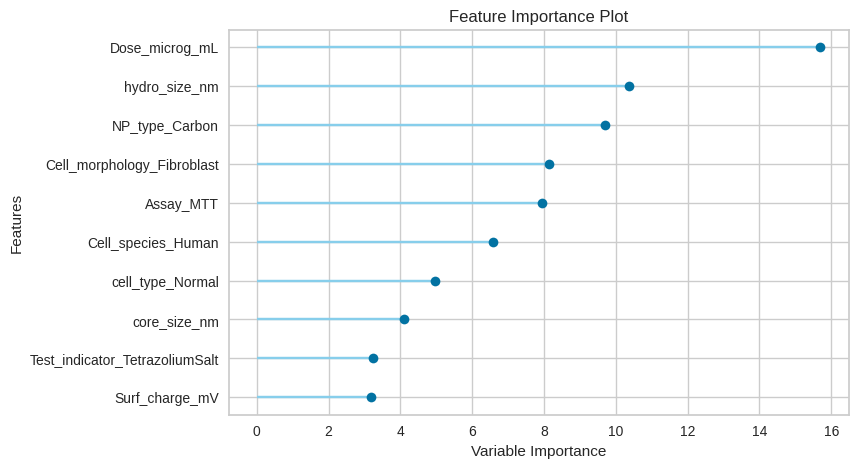

In [45]:
plot_model(final_model, plot = 'feature')

### Save the model to file

In [46]:
save_config('output/models/'+model_name+'_classification_config.cfg')

In [47]:
save_model(final_model, 'output/models/'+model_name+'_classification_model.mdl')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['nanomaterial_group',
                                                        'Coating', 'Cell_name'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='viability_class',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boo...
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='viability_class')),
                 ('fix_perfect', Remove_100(target='viability_class')),
                 ('